In [2]:
#####
# import libaries
# use plt.rc to create a consistent plotting style suited for time series analysis, most importantly the 'autolayout' function allows for the x-axis labels to not overlap
# I first saw this done here: https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series
# documentation for plt.rc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rc.html
###

import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.dates as mdates
import math



In [3]:
DEBUG_KALMAN_EST= False

########
# kalmanEstimator
#
# Kalman filter implementation
#
# This Kalman filter implementation makes two assumptions.
#
# 1) the process cannot be expressed as a closed form equation (such as equations of motion)
# 2) because of this, we use the mean of the measurement noise as the estimate (process)
#
# Essentially we are using a normal distribution to model the noise associated with X_bar for
# the measurement noise.  If we had an equation then we would use the equation.  
# In the case where we have an equation, we would use that equation as the process and track
# it's noise.
#
# theMeasurements- the noisy measurements
#
# returns- kalmanEstimates
##
def kalmanEstimator(theMeasurements):
    timeSteps= len(theMeasurements)
    
    ####
    # parameters for estimate's 
    # Gaussian noise model
    #
    # Est ~ N(mu,sigmaSq)
    ###
    muEst= 0.0
    muEstOld= 0.0
    
    sigmaSqEst= 1.0
    sigmaSqEstOld= 1.0


    ####
    # parameters for measurement's
    # noise model
    #
    # Meas ~ N(mu,sigmaSq)
    ###

    muMeas= 0.0
    muMeasOld= 0.0

    sigmaSqMeas= 1.0
    sigmaSqMeasOld= 1.0


    #####
    #  Noisy measurement
    ##
    x_k= 0.0

    #####
    # Estimate at time-step k
    ###
    x_est_k= 0.0

    #####
    # Estimate at time-step (k-1)
    ###
    x_est_km1= 0.0


    #####
    # Kalman smoothed estimates
    ###
    kalmanEstimates= []

    #####
    # Kalman Gains
    ###
    kalmanGains= []

    DEBUG= False


    #####
    # Iterate over time steps and
    # take each noisy measurement
    ###

    if (DEBUG_KALMAN_EST):
        print(f'kalmanEstimator:  there are {timeSteps} timeSteps')
    
    for k in range(timeSteps):
    
        if (DEBUG_KALMAN_EST):
            print(f'--------- time-step({k})----------')
        
        ####
        # The estimate at time-step k is the mean of the measurement dist
        # update the estimate noise model
        ##
    
        muEstOld= muEst
        sigmaSqEstOld= sigmaSqEst
        x_est_km1= x_est_k
        x_est_k= muMeas
    
        ######
        #  The estimate (process) will be the mean of the measurements. 
        #  Because we don't have an ideal equation for temperature, we will use the mean
        #  of the measurement as the noisy process model.   The mean changes and we track its
        #  noise using a normal distribution.
        #
        #  This is a distribution of the mean.  We use it's mean as the estimate
        #
        #  Note above:   x_est_k <-- muMeas
        ##
        muEst, sigmaSqEst= updateNormalParams(x_est_k, muEst, muEstOld, sigmaSqEst, sigmaSqEstOld, k)
    
        if (DEBUG_KALMAN_EST):
            print(f'muEst= {muEst}, sigmaSqEst={sigmaSqEst}')
        
        ####
        # make a measurement
        ##
    
        x_k= theMeasurements[k]
    
    
        ####
        # update measurement noise.
        # The mesurement is obtained from the hourly temperature data set.
        # 
        # Notice here we incrementally maintain the measurement distributions
        ##
    
        muMeasOld= muMeas
        sigmaSqMeasOld= sigmaSqMeas
    

        muMeas, sigmaSqMeas= updateNormalParams(x_k, muMeas, muMeasOld, sigmaSqMeas, sigmaSqMeasOld, k)
    
        if (DEBUG_KALMAN_EST):
            print(f'muMeas= {muMeas}, sigmaSqMeas={sigmaSqMeas}')
  
   
        #####
        # compute the Kalman gain
        ###
    
        KG = sigmaSqEst/(sigmaSqEst + sigmaSqMeas)
    
        if (DEBUG_KALMAN_EST):
            print(f'KG= {KG}')
    
        #####
        # compute the new estimate
        ###
        x_est_k= x_est_km1 +  KG * (x_k - x_est_km1)
    
    
        kalmanEstimates.append(x_est_k)
        kalmanGains.append(KG)

        
    return kalmanEstimates, kalmanGains
    
    ####
#  The practical issue is what do we do about parameters mu and sigmaSq
#  if we get new data.
#
#  We can compute them from the samples, and use what we compute as parameters
#  for the Normal distribution at that point.   When new data arrives, we can
#  recalculate the mean and the variance.
#
#       mu:   X_bar= 1/n Sum_i  x_i
#
#  sigmaSq:   s^2= 1/2 Sum_i (x_i - mu)^2
#
#  There's a huge problem. This requires O(n) time-steps n-many times to compute
#  the parameters. This is quite inefficient, albeit polynomial.   Incremental
#  versions of the mean and variance are derived.
#
#  http://datagenetics.com/blog/november22017/index.html
#  https://cpsc.yale.edu/sites/default/files/files/tr222.pdf
#
#  In this exercise, the experiment demonstrates how the estimated mean and variance
#  changes as incremental data arrives.  What this demonstrates is the ability for
#  incremental algorithm to track with the ground truth.  
#
#  KEEP IN MIND:
#  In the real world, you don't get to see the ground truth mean and variance.
#  You are only getting to see it in this exercise so that you can prove to yourself
#  that the incremental algorithms actually work.
#
#  Note:  When using the incremental update algorithm for mu, sigmaSq parameters of
#         Gaussian process, you need variables for current time step mu(n)/sigmaSq(n)
#         and the previous time-step  mu(n-1)/sigmaSq(n-1) as a requirment for the
#         algorithm.   An object would be more appropriate in maintaining the previoius
#         values as instance variables, but that is not the point of this course.
####

mu_n= 0
mu_nm1= mu_n

sigmasq_n= 0
sigmasq_nm1= sigmasq_n

mu_vals= []
sigmasq_vals= []

step= 0
n= 0

DEBUG_UPDATE_NORM= False

#####
# updates parameters of normal using sequential algorithm
##
def updateNormalParams(x_n, mu_n, mu_nm1, sigmasq_n, sigmasq_nm1,step):
    #global mu_n
    #global mu_nm1
    #global sigmasq_n
    #global sigmasq_nm1
    #global step
    
    new_mu= None
    new_sigmasq= None
    
    ###
    # Note:
    # For the algorithm, n must start from 2, why? 
    # because (n-1) term in denominator would be zero if
    # n started at 1.  This would cause overflow due to infinity
    ##
    step+= 1
    n= step + 1
    
    mu_n= mu_nm1 + (x_n - mu_nm1)/n
    sigmasq_n= sigmasq_nm1 + math.pow(x_n - mu_nm1,2)/n - sigmasq_nm1/(n-1)
    
    if (DEBUG_UPDATE_NORM):
        print(f'updateNomralParams:   n= {n}, x_n= {x_n},  x_n - mu_nm1= {x_n- mu_nm1}')
        print(f'updateNomralParams:   mu_n= {mu_n}, mu_nm1= {mu_nm1}, sigmasq_n= {sigmasq_n}, sigmasq_nm1= {sigmasq_nm1}')

    new_mu= mu_n
    new_sigmasq= sigmasq_n
    
    mu_nm1= mu_n
    sigmasq_nm1= sigmasq_n

    return new_mu, new_sigmasq

In [4]:
#####
# read-in data, set the index as the dates
##
data = pd.read_csv("IBM_Stock_Data.csv").set_index("Date")
data = data.rename(columns={"IBM":"Close"})

kalman_est, _ = kalmanEstimator(data['Close'].to_list())
data['kalman_smoothed_prices'] = kalman_est

data['kalman_smoothed_prices'].to_csv("IBM_kalaman_smoothed.csv")
del data['kalman_smoothed_prices']

In [5]:
#####
# Summary Statistics
##
data.describe().round(2)

,Close
count,15842.00
mean,63.84
std,57.81
min,3.90
25%,15.68
50%,29.56
75%,114.64
max,238.04


<Axes: title={'center': 'IBM Stock Price'}, xlabel='Date', ylabel='Closing Price (USD)'>

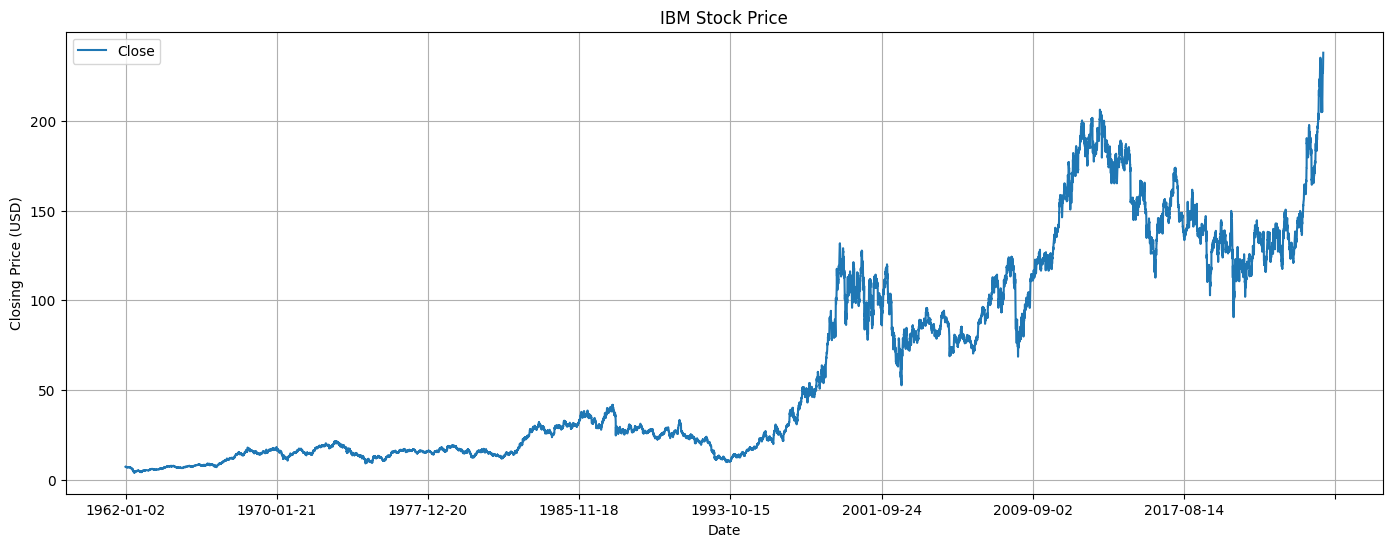

In [6]:
data.plot.line(figsize=(17,6), grid=True, ylabel="Closing Price (USD)", title="IBM Stock Price")

In [7]:
#####
# This function takes in 5 dates that seperates them into diffrent buisness cycles, 
# I made sure that each of the dates ended at the end of a quater in the market

ipo_date = "1962-01-02"
BC_1_End = "1993-03-31"
BC_2_End = "1999-01-01"
BC_3_End = "2010-09-30"
yesterday_date = "2024-12-06"

def create_Business_Cycles(stock_data, ipo_date, BC_1_End, BC_2_End, BC_3_End, yesterday_date):

    startup_data = stock_data.loc[ipo_date: BC_1_End]
    growth_data = stock_data.loc[BC_1_End: BC_2_End]
    maturity_data = stock_data.loc[BC_2_End: BC_3_End]
    stable_data = stock_data.loc[BC_3_End: yesterday_date]

    return startup_data, growth_data, maturity_data, stable_data


startup_data, growth_data, maturity_data, stable_data = create_Business_Cycles(data, ipo_date, BC_1_End, BC_2_End, BC_3_End, yesterday_date)



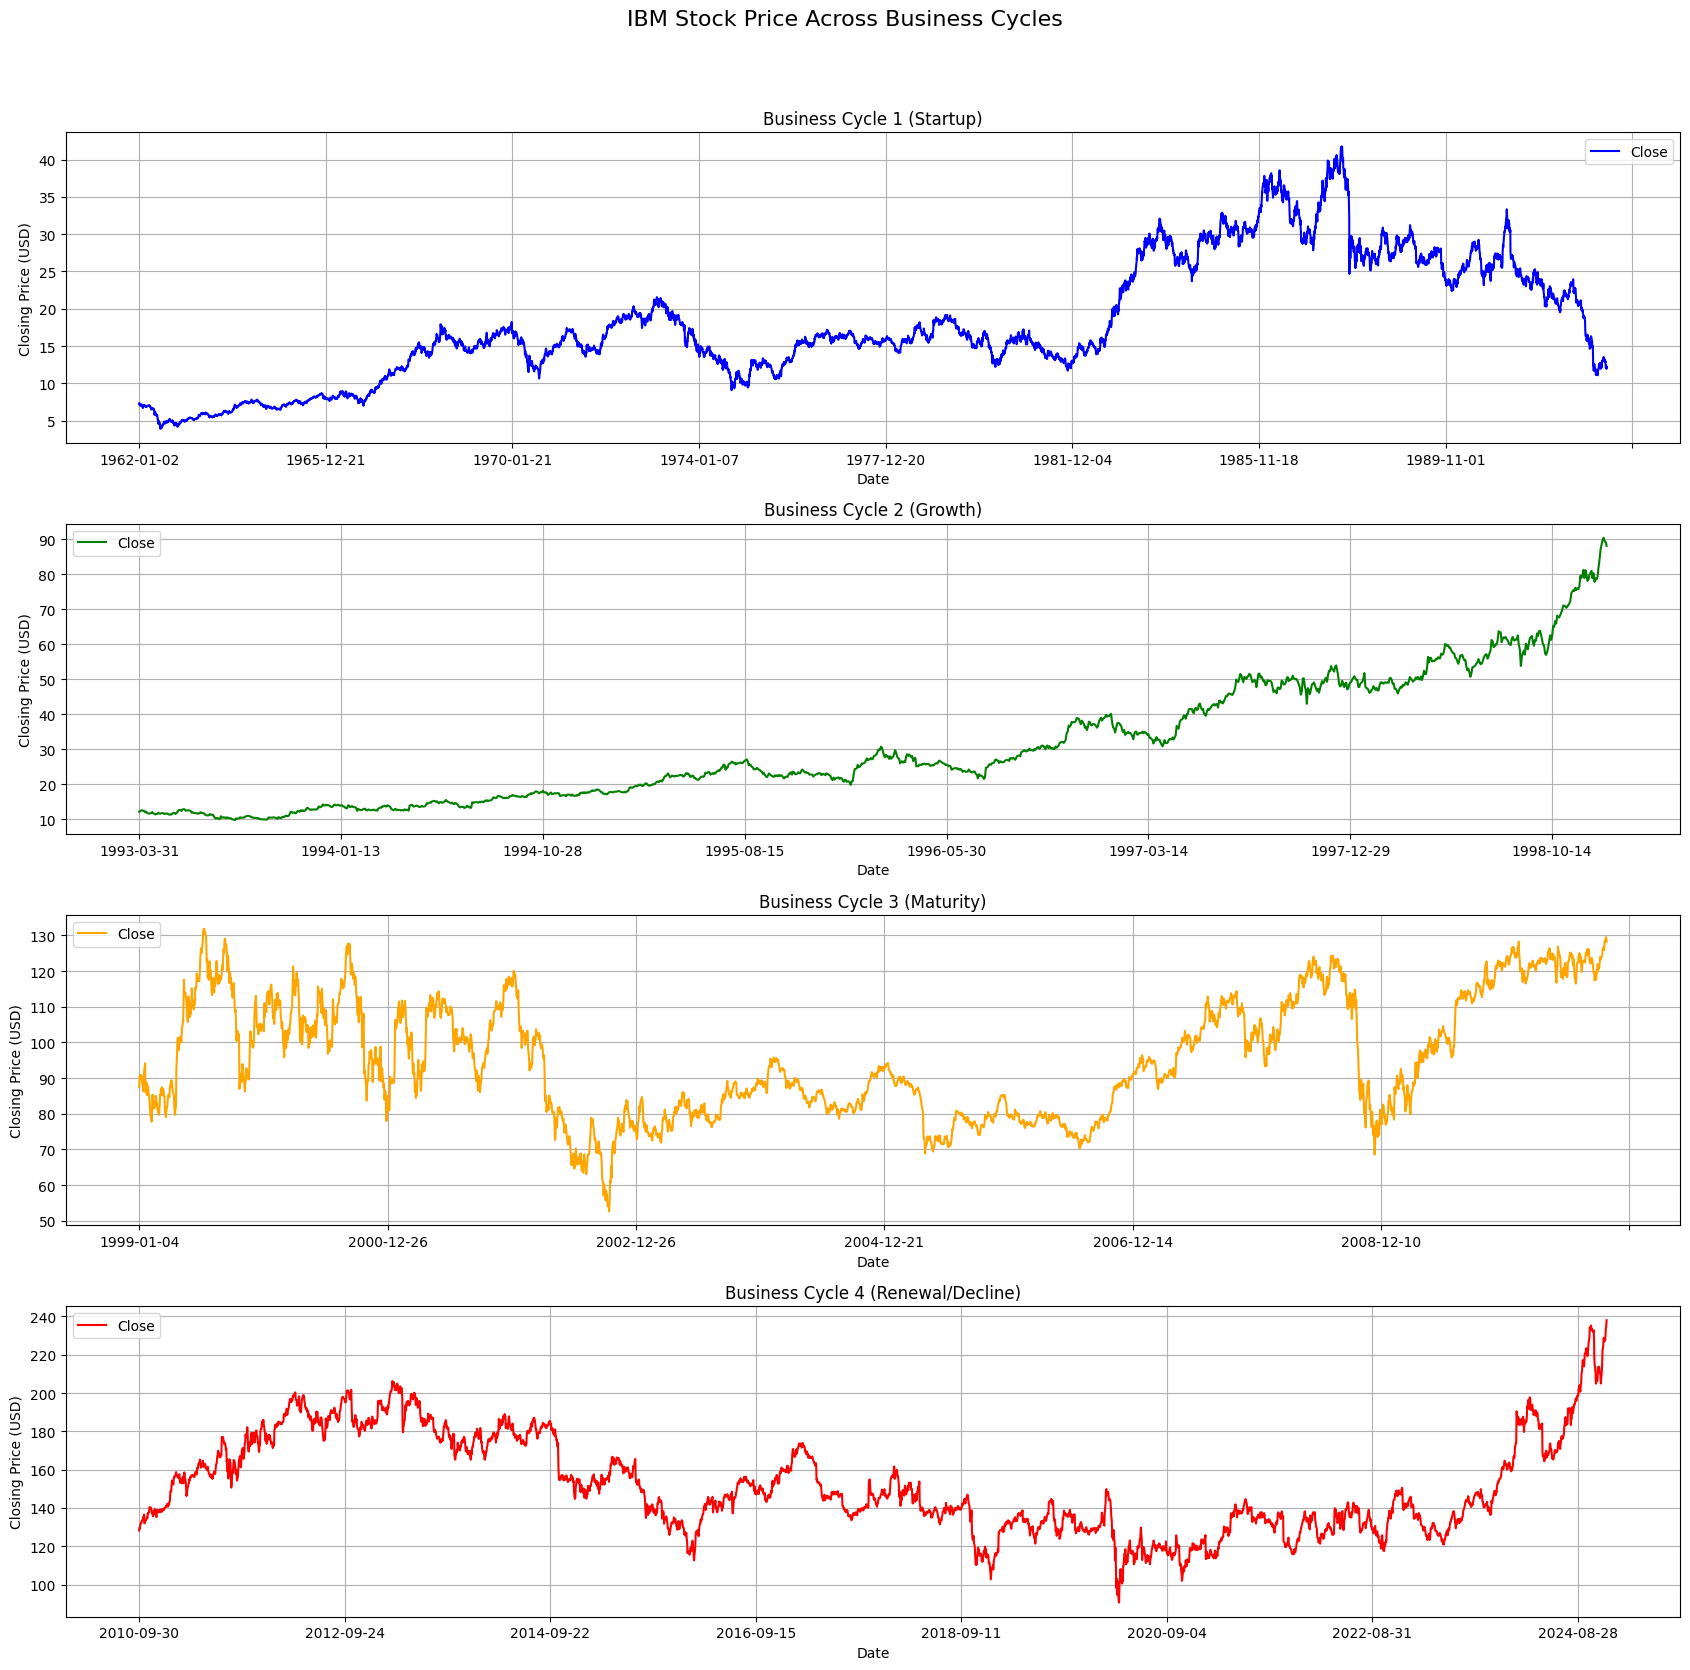

In [8]:
#####
# This function simply takes the four dataframes and use subplots to plot each time-series respectivly
###


def plot_Business_Cycles(startup_data, growth_data, maturity_data, stable_data):

    fig, axes = plt.subplots(4,1, figsize=(17,17))
    fig.suptitle("IBM Stock Price Across Business Cycles", fontsize=16)

      # Plot each business cycle
    startup_data.plot(ax=axes[0], title="Business Cycle 1 (Startup)", color='blue', grid=True)
    axes[0].set_ylabel("Closing Price (USD)")
    
    growth_data.plot(ax=axes[1], title="Business Cycle 2 (Growth)", color='green', grid=True)
    axes[1].set_ylabel("Closing Price (USD)")
    
    maturity_data.plot(ax=axes[2], title="Business Cycle 3 (Maturity)", color='orange', grid=True)
    axes[2].set_ylabel("Closing Price (USD)")
    
    stable_data.plot(ax=axes[3], title="Business Cycle 4 (Renewal/Decline)", color='red', grid=True)
    axes[3].set_ylabel("Closing Price (USD)")
    axes[3].set_xlabel("Date")

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_Business_Cycles(startup_data, growth_data, maturity_data, stable_data)

#### Here I will expirenement with different window sizes for a simple moving average

In [9]:
def compute_sma(time_series, windows):
    time_series_copy = time_series.copy()

    for window in windows:
        time_series_copy.loc[:, f"sma_{window}"] = time_series_copy["Close"].rolling(window, min_periods=1).mean()

    return time_series_copy

def compute_ema(time_series, windows):
    time_series_copy = time_series.copy()

    for window in windows:
        time_series_copy.loc[:, f"ema_{window}"] = time_series_copy["Close"].ewm(window, min_periods=1).mean()

    return time_series_copy

def format_xticks(axes):
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Major ticks every 5 years
        ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Minor ticks every year
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick labels as years


In [10]:
def plot_sma(ax, sma_data, sma_windows):
    for window in sma_windows:
        ax.plot(sma_data.index, sma_data[f"sma_{window}"], label=f"SMA {window}")
    ax.set_title("Simple Moving Averages")
    ax.set_ylabel("Price (USD)")
    ax.grid(True)
    ax.legend()

def plot_ema(ax, ema_data, ema_windows):
    for window in ema_windows:
        ax.plot(ema_data.index, ema_data[f"ema_{window}"], label=f"EMA {window}")
    ax.set_title("Exponential Moving Averages")
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Date")
    ax.grid(True)
    ax.legend()

def plot_kalman(ax, time_series, kalman_estimates):
    ax.plot(time_series.index[:len(kalman_estimates)], kalman_estimates, label="Kalman Estimates", color="blue")
    ax.plot(time_series.index, time_series["Close"], label="Actual Data", color="orange", alpha=0.6)
    ax.set_title("Kalman Filter Estimates vs Actual Data")
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Date")
    ax.grid(True)
    ax.legend()

In [11]:
def plot_SMA_EWM_Business_Cycles(time_series, sma_windows, ema_windows, kalman_measurements, title):
    # Compute SMA and EMA
    sma_data = compute_sma(time_series, sma_windows)
    ema_data = compute_ema(time_series, ema_windows)
    # Run the Kalman filter
    kalman_estimates, _ = kalmanEstimator(kalman_measurements)

    # Create subplot
    fig, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(title, fontsize=16)

    # Plot SMA, EMA, and Kalman filter estimates
    plot_sma(axes[0], sma_data, sma_windows)
    plot_ema(axes[1], ema_data, ema_windows)
    plot_kalman(axes[2], time_series, kalman_estimates)

    # Format x-ticks
    format_xticks(axes)

    # Adjust layout and show plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

sma_windows = [5, 90, 365]
ema_windows = [5, 90, 365]


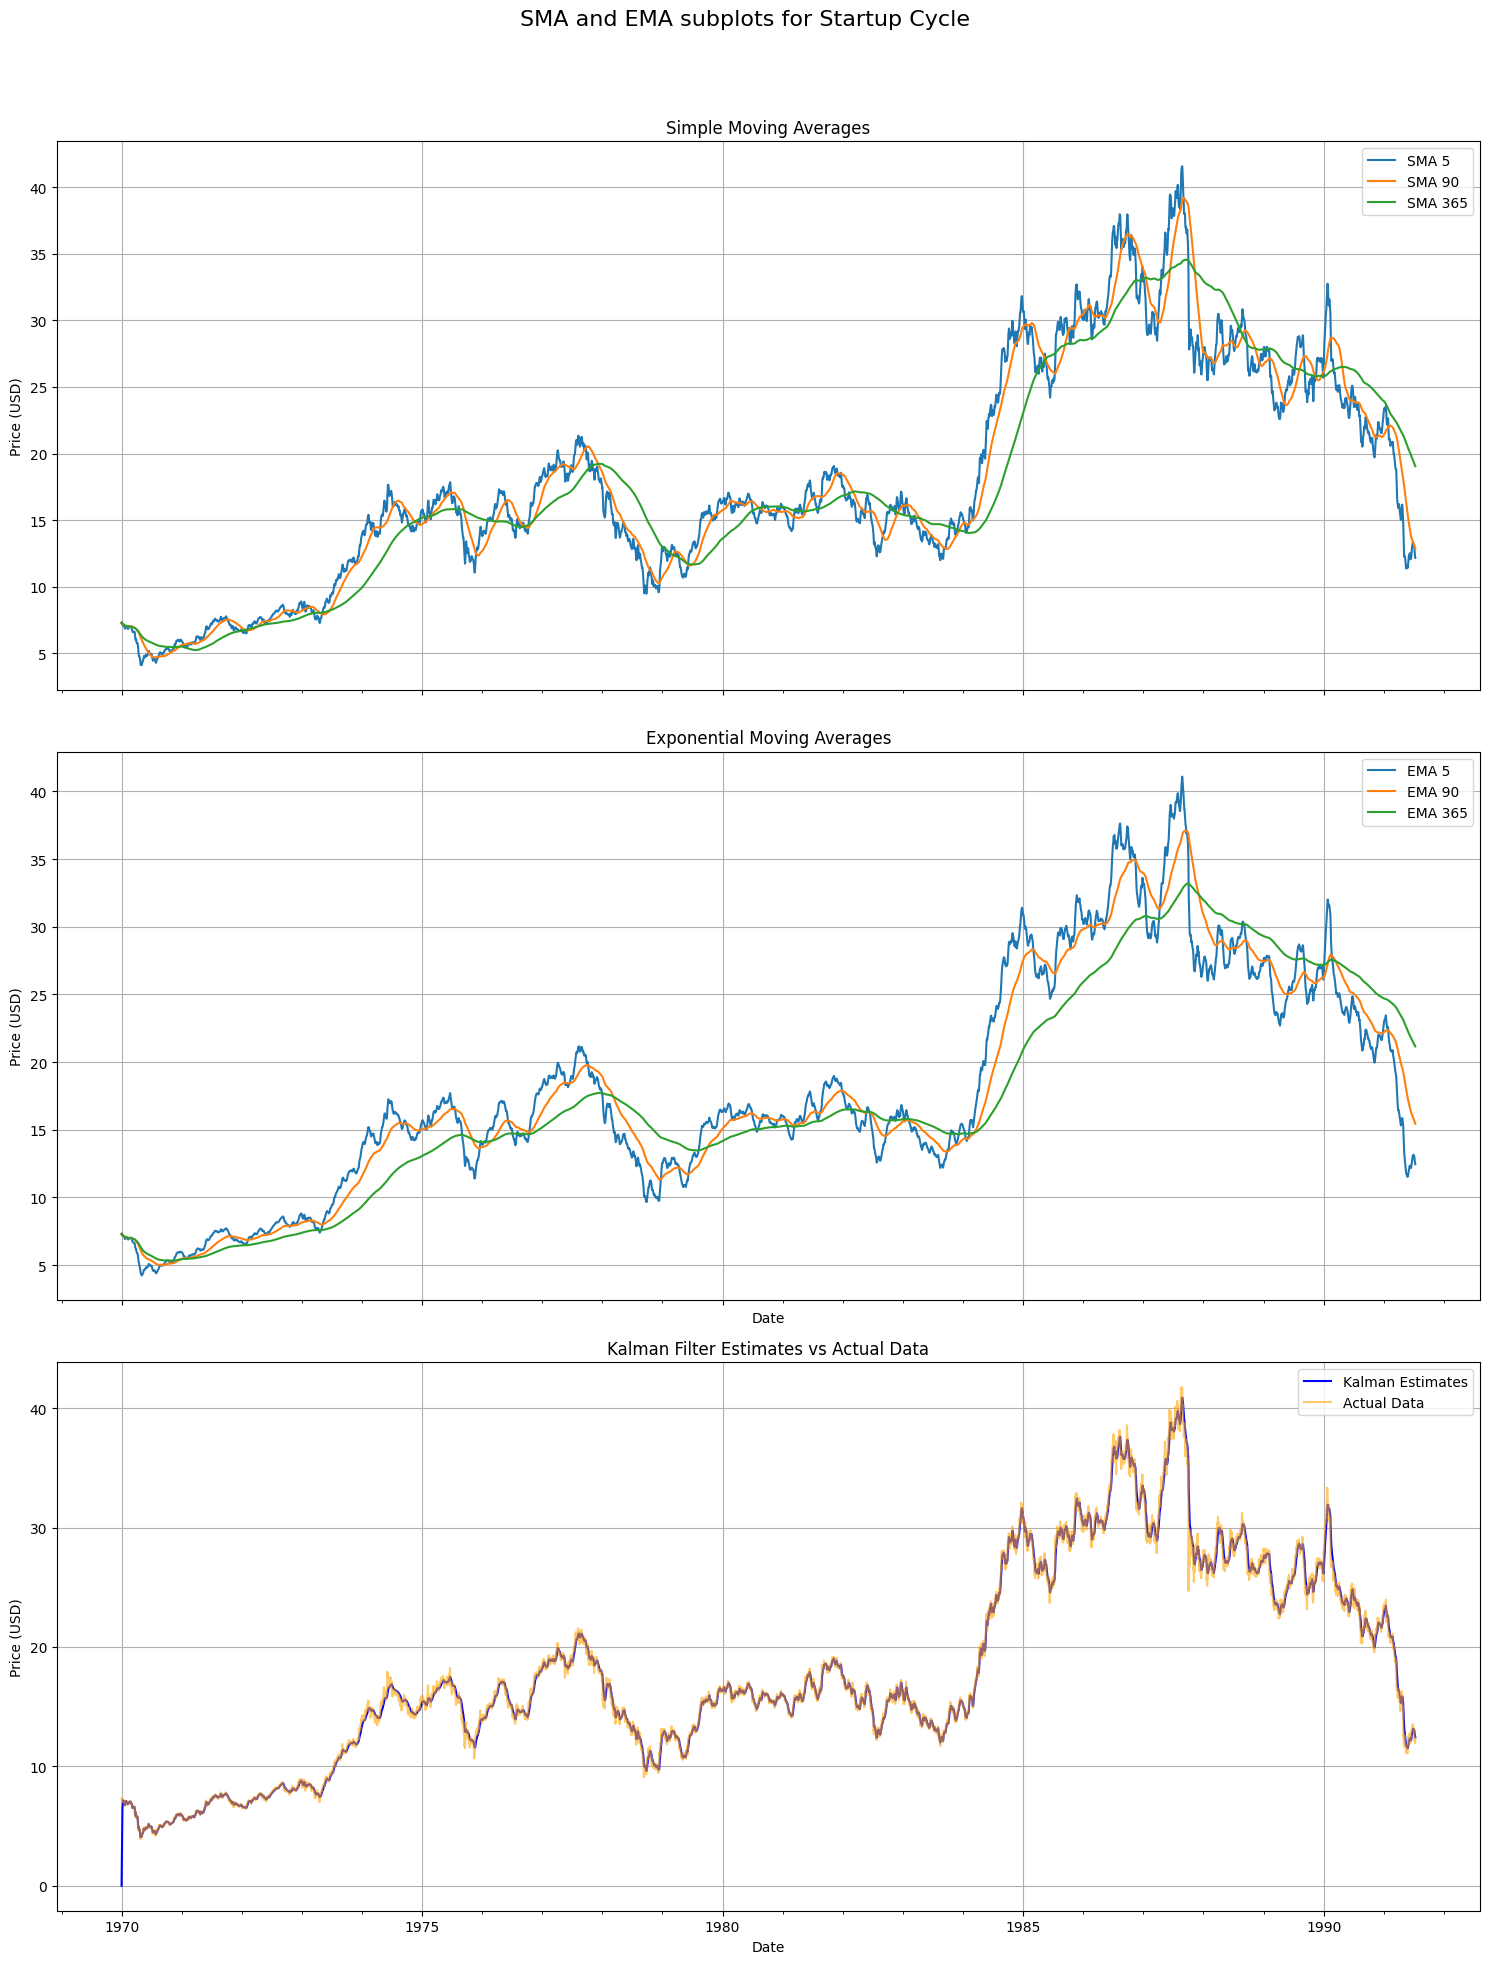

In [12]:
plot_SMA_EWM_Business_Cycles(startup_data, sma_windows, ema_windows,
                            kalman_measurements=startup_data["Close"].tolist(), 
                            title="SMA and EMA subplots for Startup Cycle")

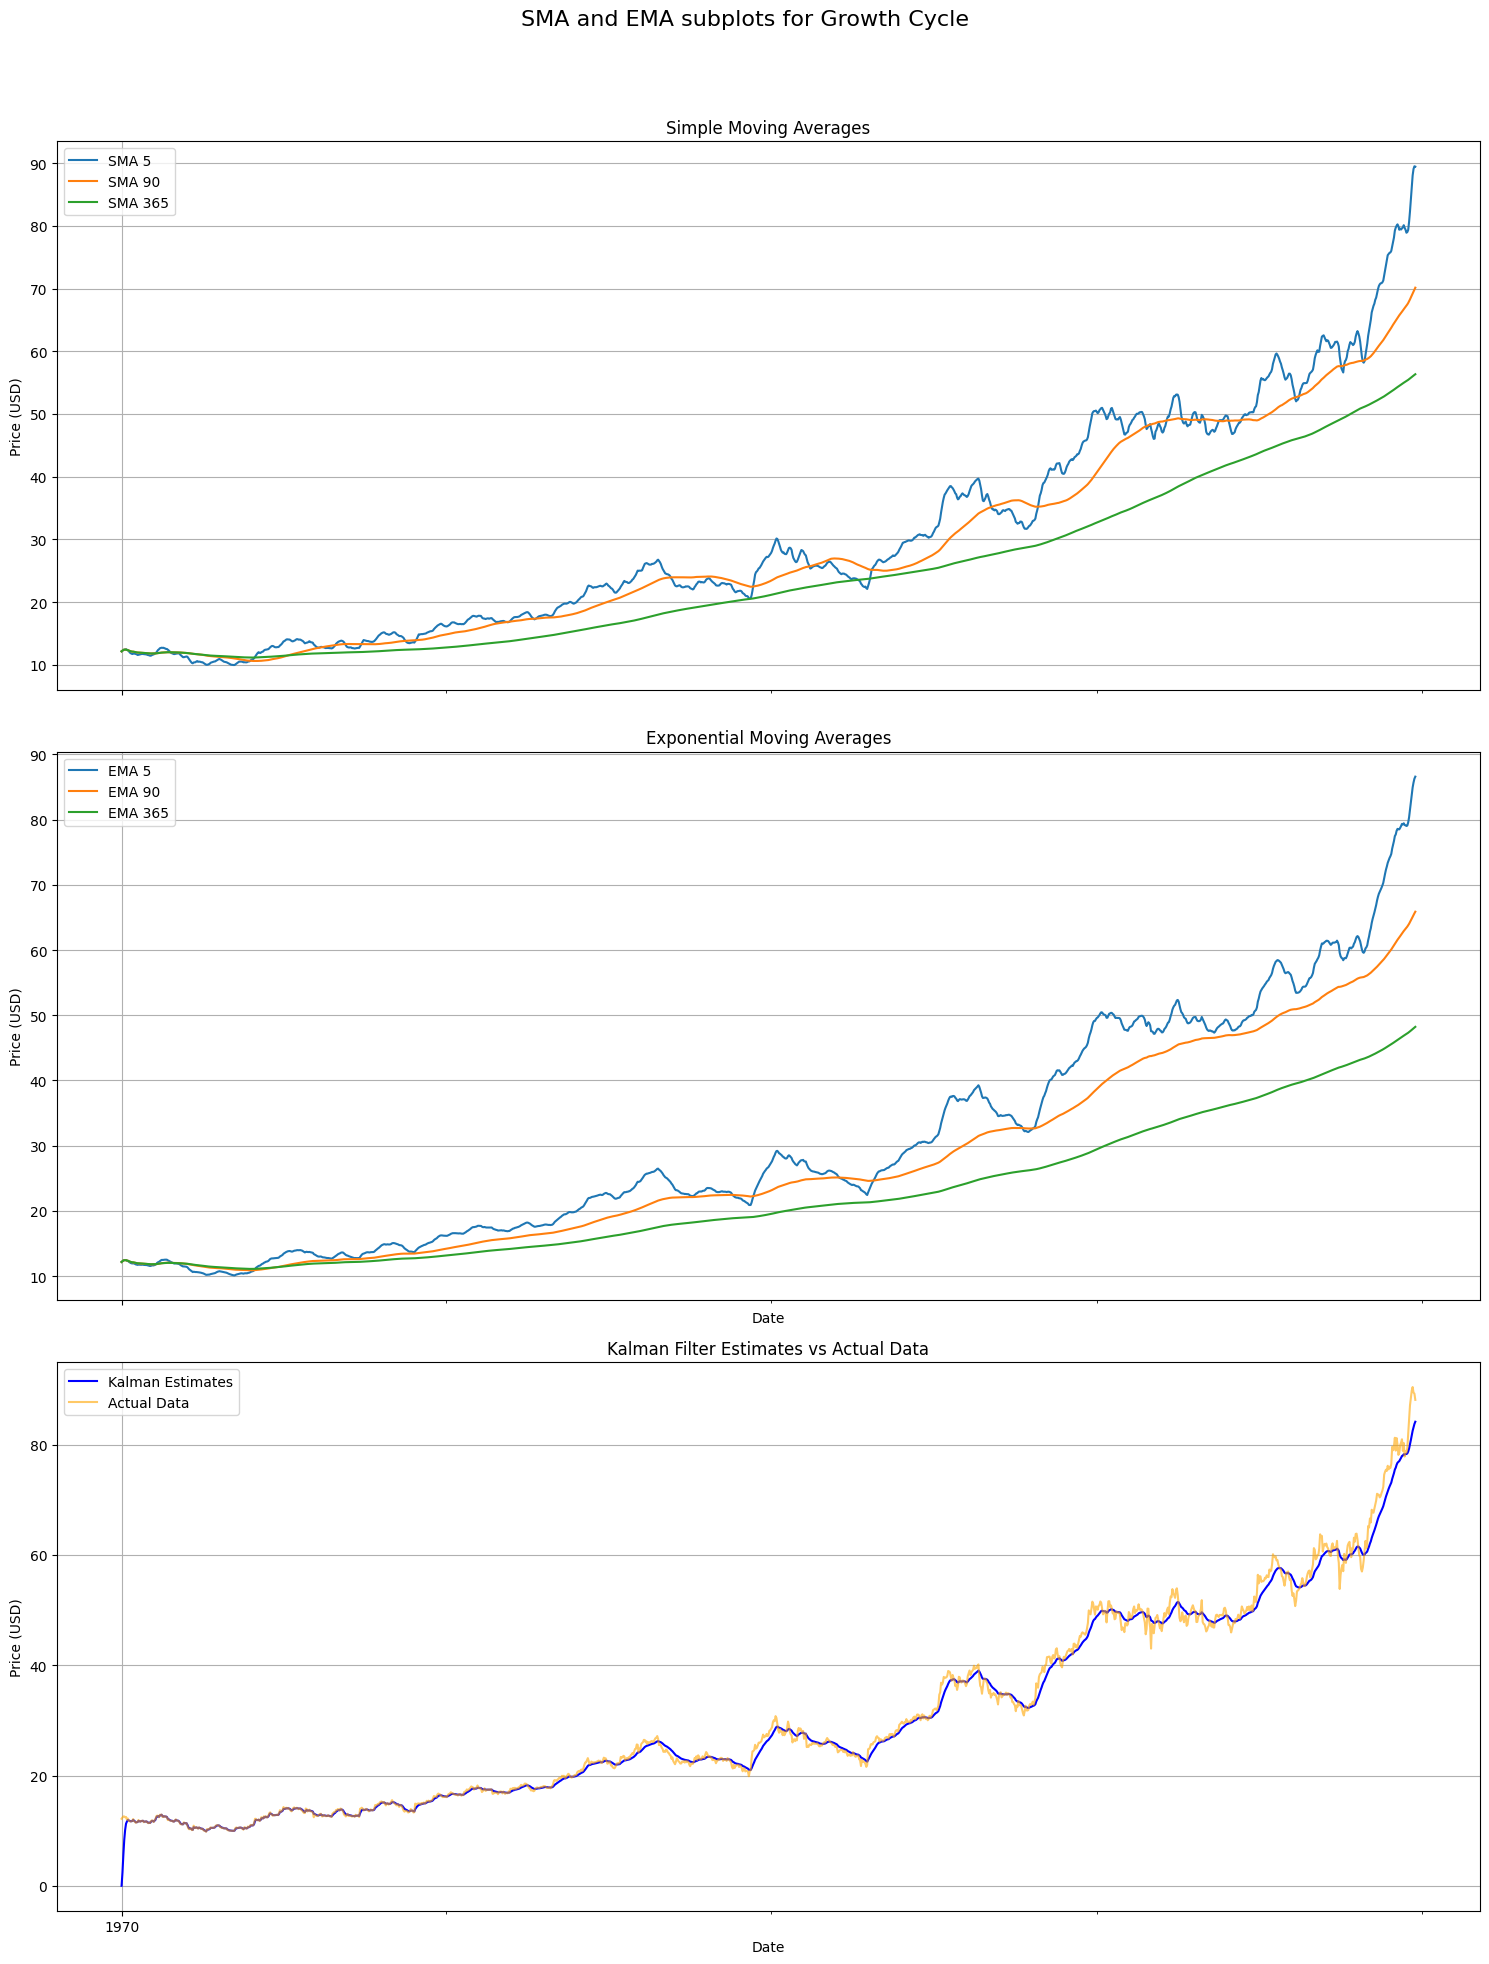

In [13]:
plot_SMA_EWM_Business_Cycles(growth_data, sma_windows, ema_windows,
                            kalman_measurements=growth_data["Close"].tolist(), 
                            title="SMA and EMA subplots for Growth Cycle")


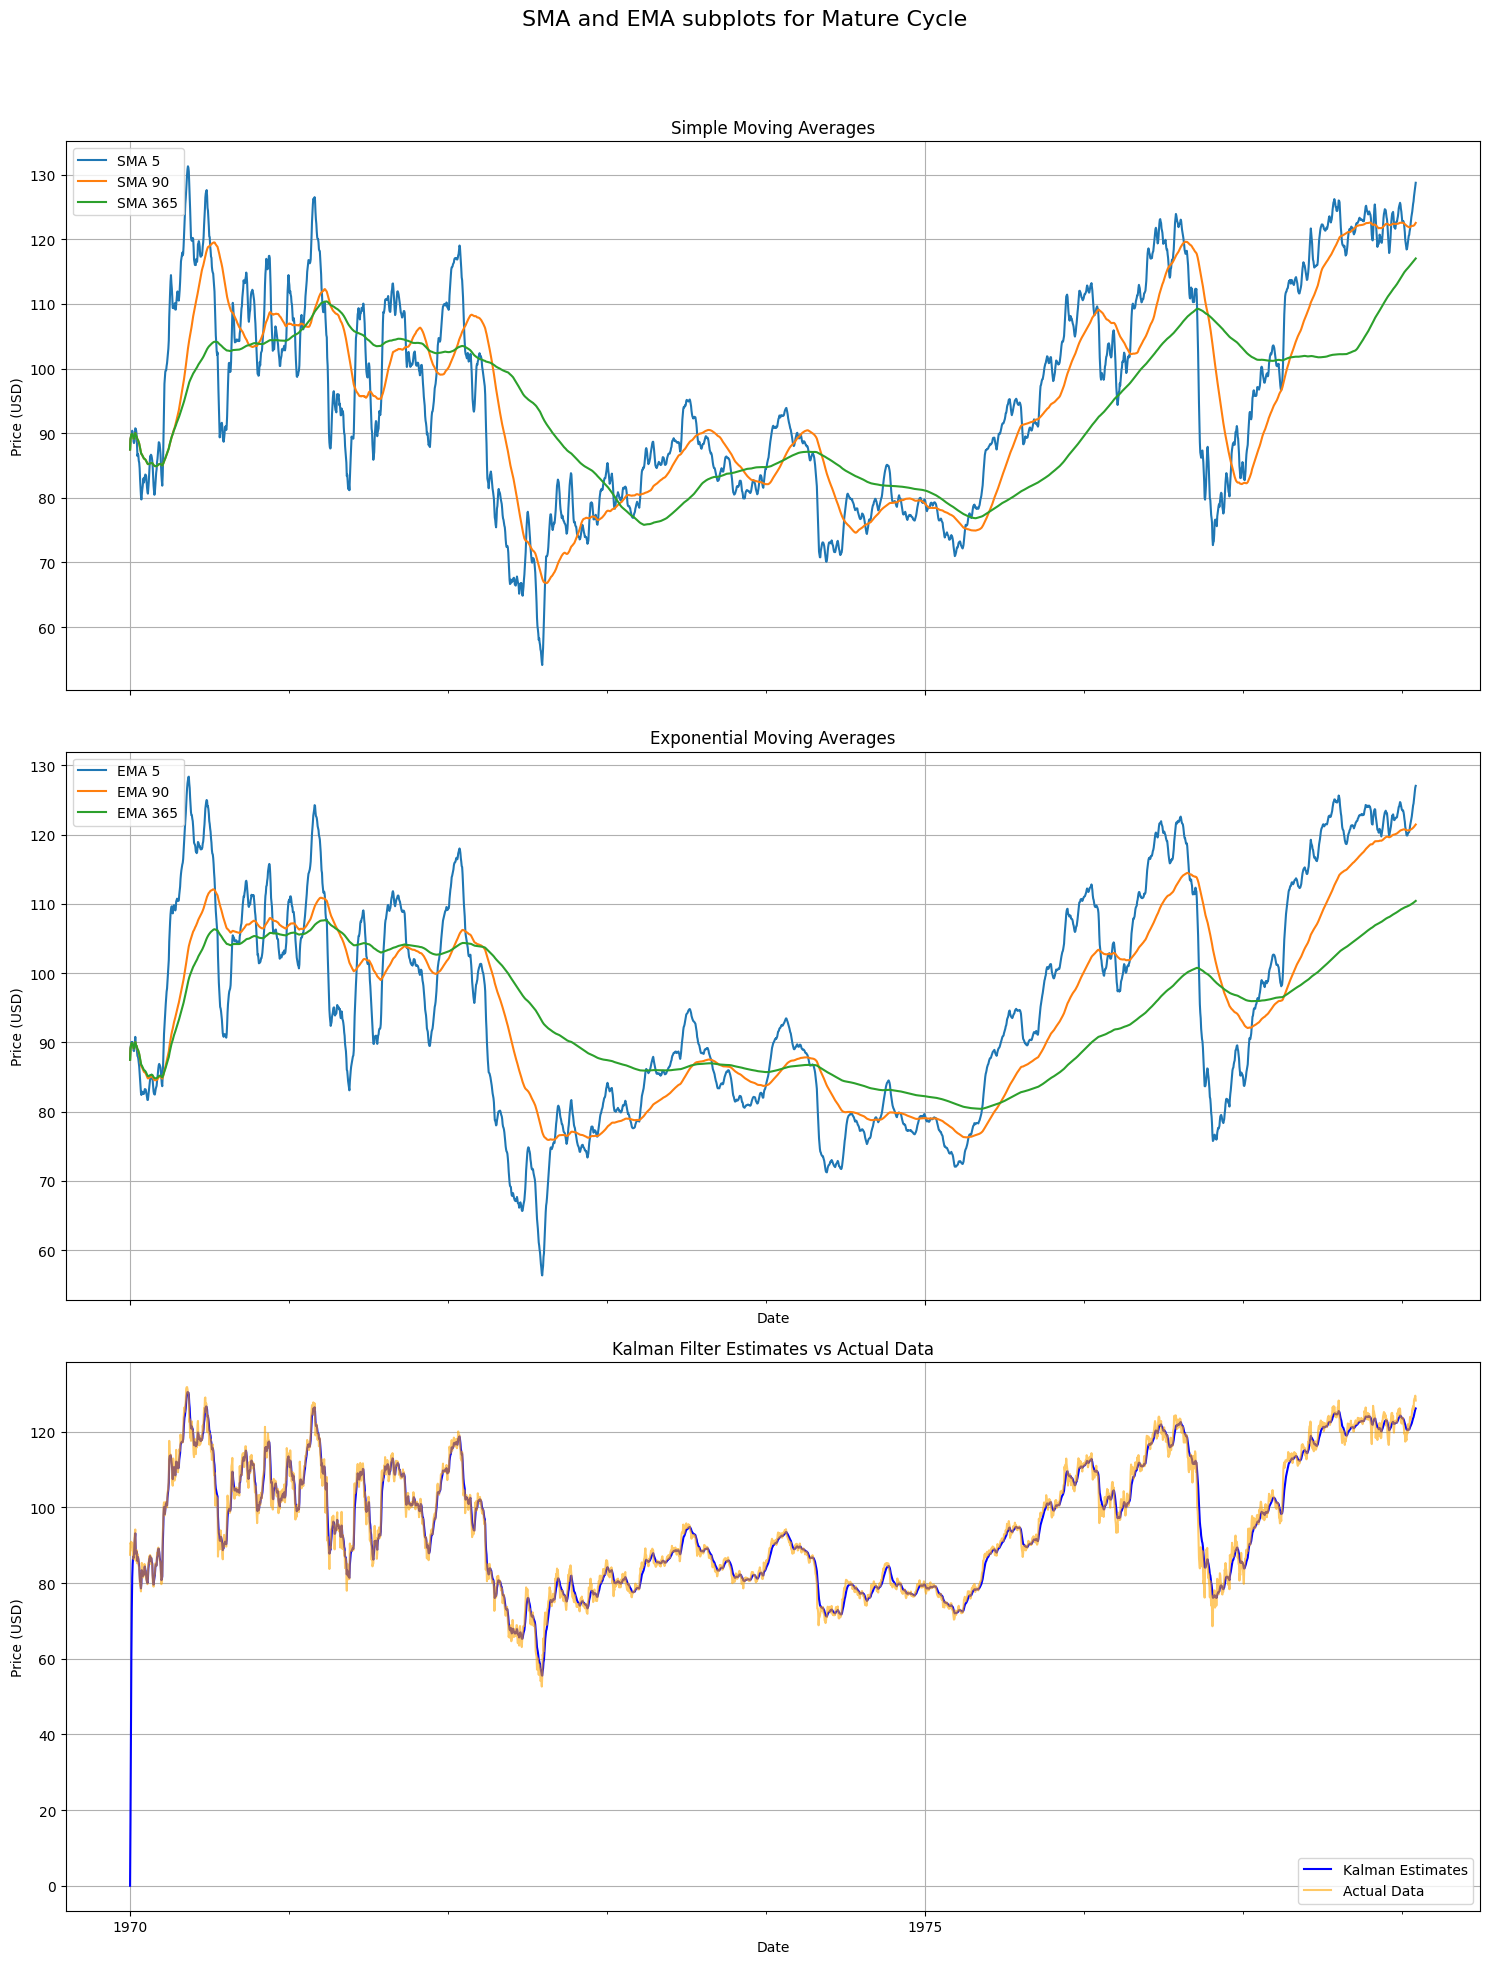

In [14]:
plot_SMA_EWM_Business_Cycles(maturity_data, sma_windows, ema_windows, 
                             kalman_measurements=maturity_data["Close"].to_list(),
                             title="SMA and EMA subplots for Mature Cycle")

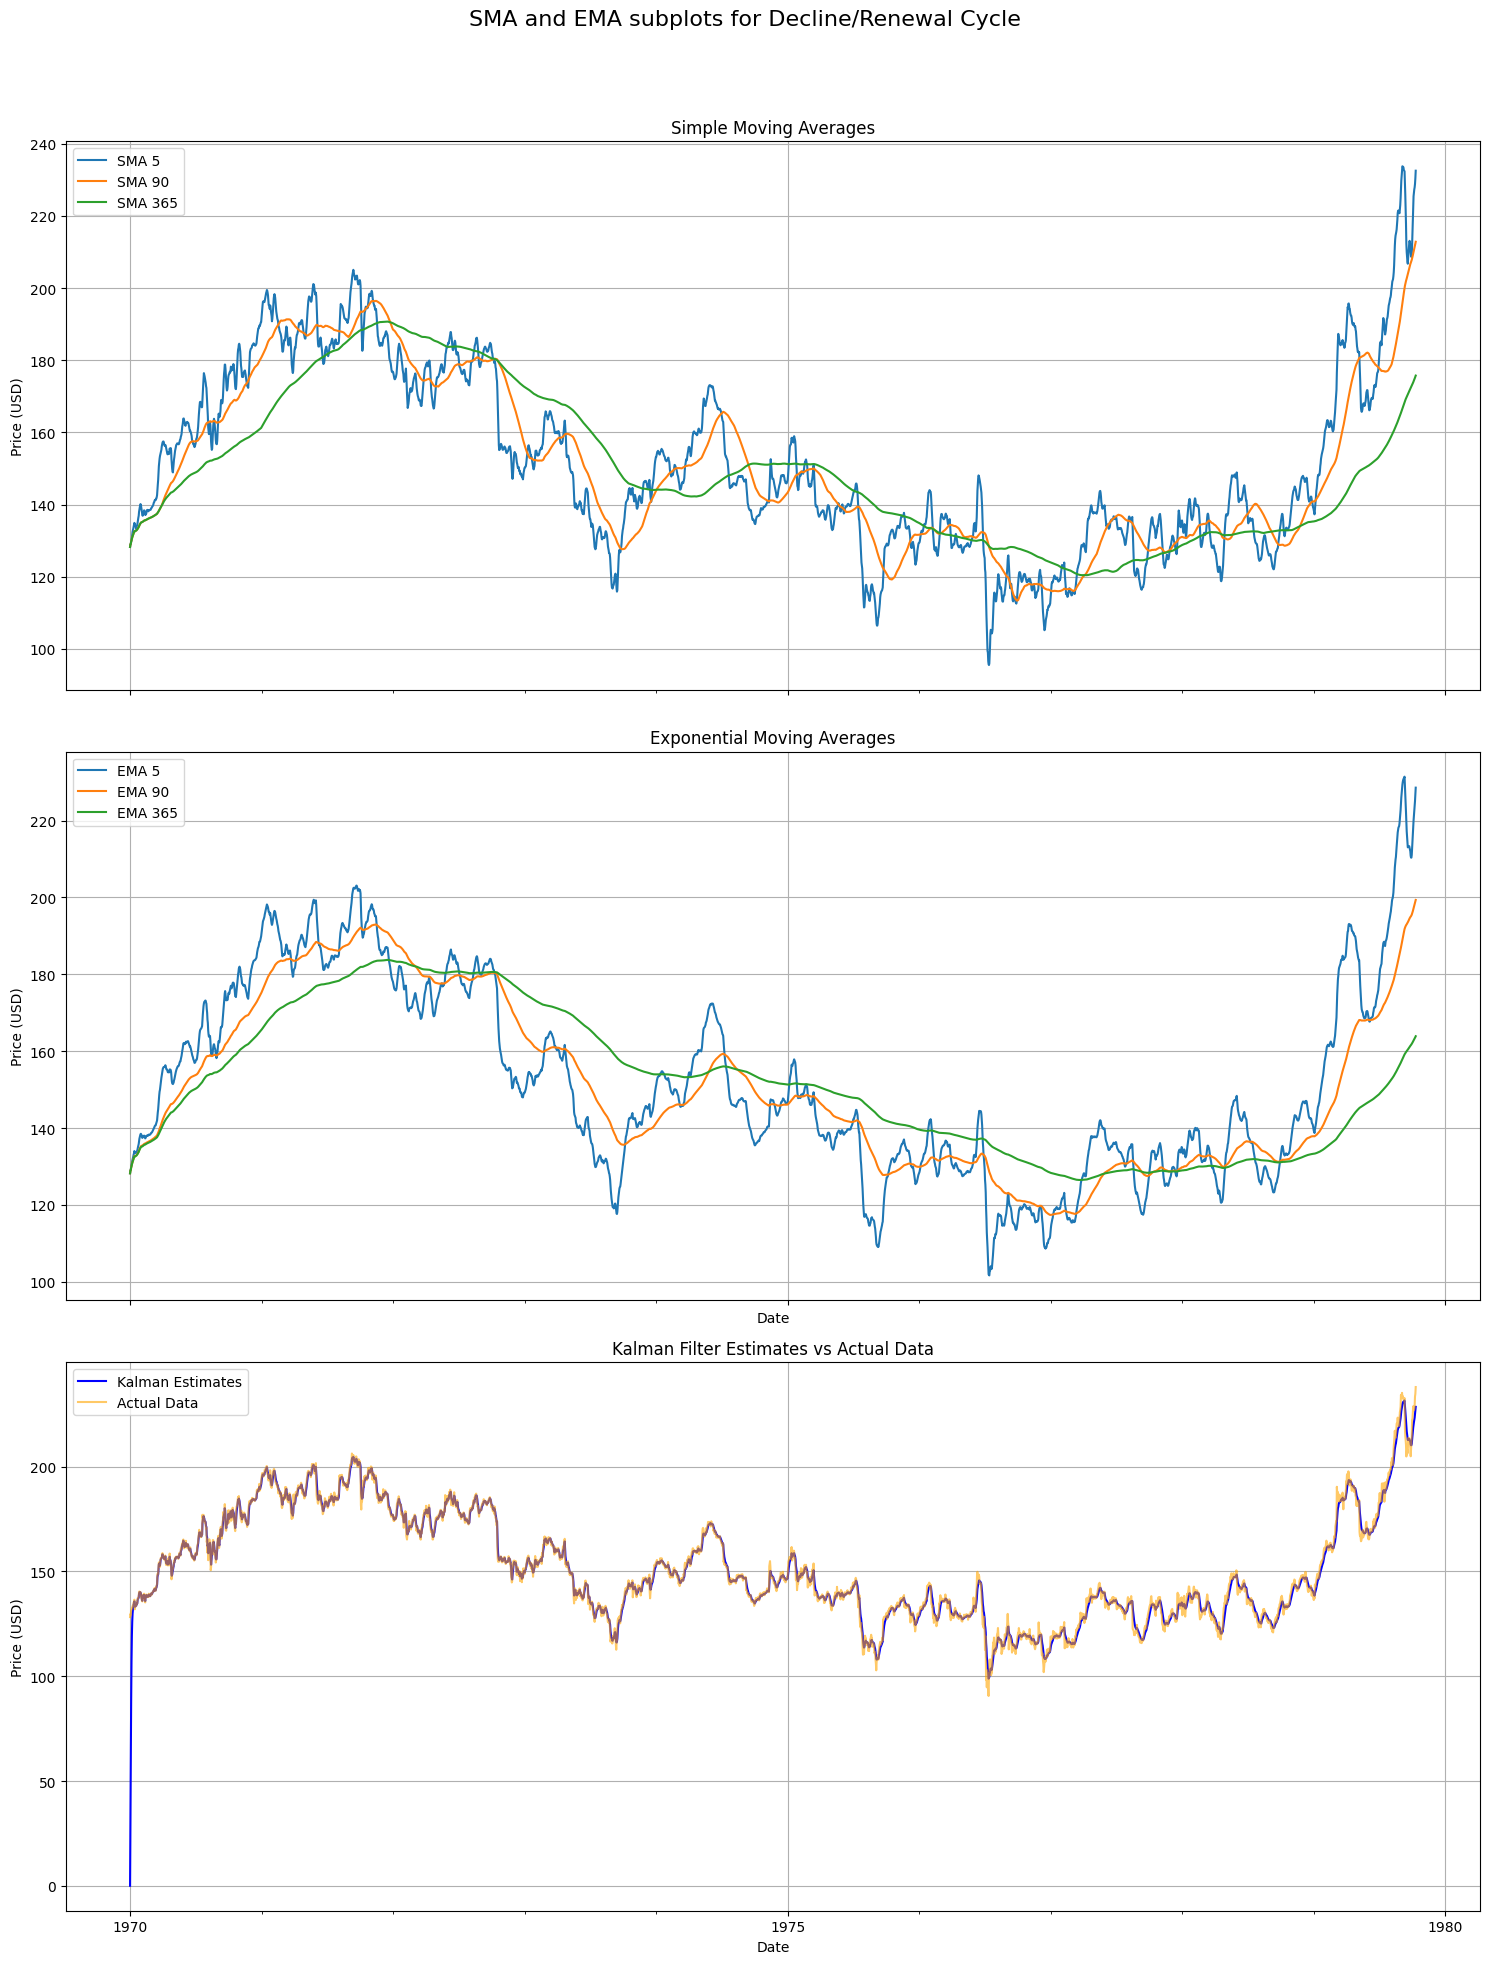

In [15]:
plot_SMA_EWM_Business_Cycles(stable_data, sma_windows, ema_windows, 
                             kalman_measurements=stable_data["Close"].to_list(),
                             title="SMA and EMA subplots for Decline/Renewal Cycle")